In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv("../../datasets/Bengaloredataset/bangalore_inflation_dataset.csv", parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

print("📊 Dataset Shape:", df.shape)
print(df.head())


📊 Dataset Shape: (200, 13)
        Date       CPI  GDP_Growth  Unemployment_Rate  Crude_Oil_Prices  \
0 2007-01-31  4.318798    2.246895           7.220601         41.382887   
1 2007-02-28  5.553752    7.239423          10.231640         57.094225   
2 2007-03-31  4.200890    4.729275           7.419760         63.795917   
3 2007-04-30  4.750935    3.620667           5.795134         98.315315   
4 2007-05-31  7.757629    4.751309           6.885443         78.348297   

   Gold_Prices  Real_Estate_Index   Stock_Index  Money_Supply_M1  \
0  1537.035107         135.252643  21528.193539         5.834372   
1  1585.088973         136.279335  21842.671646         5.199187   
2  1544.457971         123.954010  30149.436287         6.348152   
3  1755.773163         126.866871  24002.048457        10.478388   
4  1309.536724         140.203776  26346.390005         7.321637   

   Money_Supply_M2  Industrial_Production  Retail_Sales  Exchange_Rate  
0         9.409519               5.48731

In [3]:
# Frature engineering

df_fe = df.copy()

# Add lags for major indicators
for col in ["CPI", "GDP_Growth", "Unemployment_Rate",
            "Crude_Oil_Prices", "Gold_Prices",
            "Real_Estate_Index", "Stock_Index"]:
    for lag in [1, 3, 6, 12]:
        df_fe[f"{col}_lag{lag}"] = df_fe[col].shift(lag)

# Moving averages for smoother trends
for col in ["CPI", "Gold_Prices", "Stock_Index"]:
    df_fe[f"{col}_ma3"] = df_fe[col].rolling(window=3).mean()
    df_fe[f"{col}_ma6"] = df_fe[col].rolling(window=6).mean()

# Volatility for market-driven features
for col in ["Stock_Index", "Gold_Prices"]:
    df_fe[f"{col}_volatility"] = df_fe[col].rolling(window=3).std()

# Seasonality (month sin/cos)
df_fe["month"] = df_fe["Date"].dt.month

df_fe["month_sin"] = np.sin(2 * np.pi * df_fe["month"] / 12)
df_fe["month_cos"] = np.cos(2 * np.pi * df_fe["month"] / 12)
df_fe.drop(columns=["month"], inplace=True)

# Drop NA from lag/rolling
df_fe = df_fe.dropna().reset_index(drop=True)

print("✅ After Feature Engineering:", df_fe.shape)


✅ After Feature Engineering: (188, 51)


In [4]:
target_col = "CPI"   
features = df_fe.drop(columns=["Date", target_col])
target = df_fe[target_col]

# Scale features
X_scaler = MinMaxScaler()
features_scaled = X_scaler.fit_transform(features)

# Scale target
y_scaler = MinMaxScaler()
target_scaled = y_scaler.fit_transform(target.values.reshape(-1,1))

In [5]:
#Creating Sequence

def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i+time_steps)])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 24
X_seq, y_seq = create_sequences(features_scaled, target_scaled, TIME_STEPS)

train_size = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

print(f"✅ Train: {X_train.shape}, Test: {X_test.shape}")

✅ Train: (131, 24, 49), Test: (33, 24, 49)


In [6]:
# GRU-RNN model

model = Sequential([
    GRU(128, activation="tanh", return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    GRU(64, activation="tanh"),
    Dropout(0.2),
    Dense(64, activation="relu"),
    Dense(1)
])

model.compile(optimizer="adam", loss="mae", metrics=["mse"])
model.summary()

c:\Web development\GRU-RNN_InflationModel\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 24, 128)        │        68,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,209 (430.50 KB)

 Trainable params: 110,209 (430.50 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Training 

early_stop = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
history = model.fit(
        X_train, y_train,
           validation_data=(X_test, y_test),
           epochs=200,
           batch_size=16,
           callbacks=[early_stop],
           verbose=1
      )

Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.2055 - mse: 0.0689 - val_loss: 0.1608 - val_mse: 0.0415
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1957 - mse: 0.0667 - val_loss: 0.1677 - val_mse: 0.0397
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1607 - mse: 0.0428 - val_loss: 0.1986 - val_mse: 0.0541
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1677 - mse: 0.0473 - val_loss: 0.2606 - val_mse: 0.0908
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1825 - mse: 0.0561 - val_loss: 0.2598 - val_mse: 0.0896
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1947 - mse: 0.0539 - val_loss: 0.1551 - val_mse: 0.0377
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1654 - mse: 0.0481 - val_loss: 0.1754 - val_mse: 0.0442
Epoch 8/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1590 - mse: 0.0406 - val_loss: 0.1623 - val_mse: 0.0396
Epoch 9/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1540 - mse: 

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step


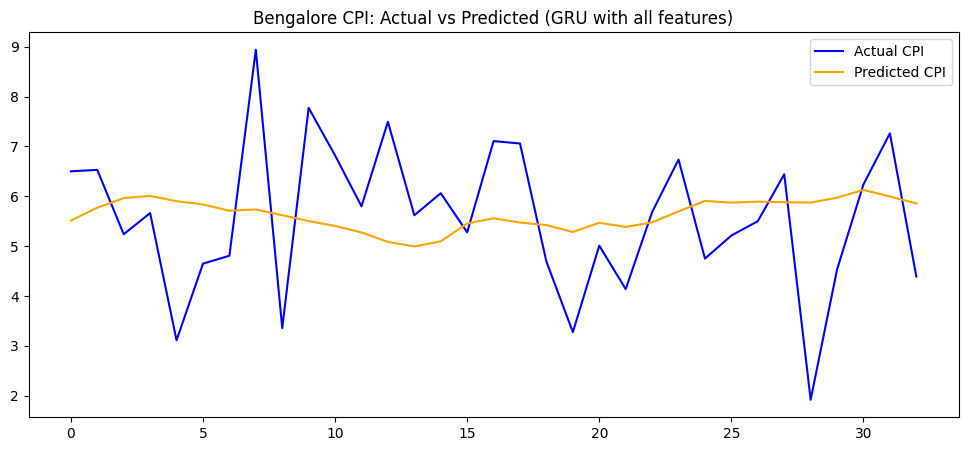

In [8]:
# Predictions 

y_pred_scaled = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_actual = y_scaler.inverse_transform(y_test)

# Plot
plt.figure(figsize=(12,5))
plt.plot(y_actual, label="Actual CPI", color="blue")
plt.plot(y_pred, label="Predicted CPI", color="orange")
plt.title("Bengalore CPI: Actual vs Predicted (GRU with all features)")
plt.legend()
plt.show()

In [9]:
mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100
r2 = r2_score(y_actual, y_pred)

print(f"📌 Target: {target_col}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

📌 Target: CPI
MAE: 1.25
RMSE: 1.54
MAPE: 28.12%
R² Score: -0.0999


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# y_actual and y_pred should be in original scale (inverse transformed if scaled)
mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100
r2 = r2_score(y_actual, y_pred)

# Approximate "accuracy" as 100 - MAPE
accuracy = 100 - mape

print(f"📌 Target: {target_col}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")
print(f"Approximate Accuracy: {accuracy:.2f}%")


📌 Target: CPI
MAE: 1.25
RMSE: 1.54
MAPE: 28.12%
R² Score: -0.0999
Approximate Accuracy: 71.88%


In [11]:
# Save trained model
model.save("Bengalore_inflation_gru_model.h5")
print("✅ Model saved as Bengalore_inflation_gru_model.h5")

✅ Model saved as Bengalore_inflation_gru_model.h5


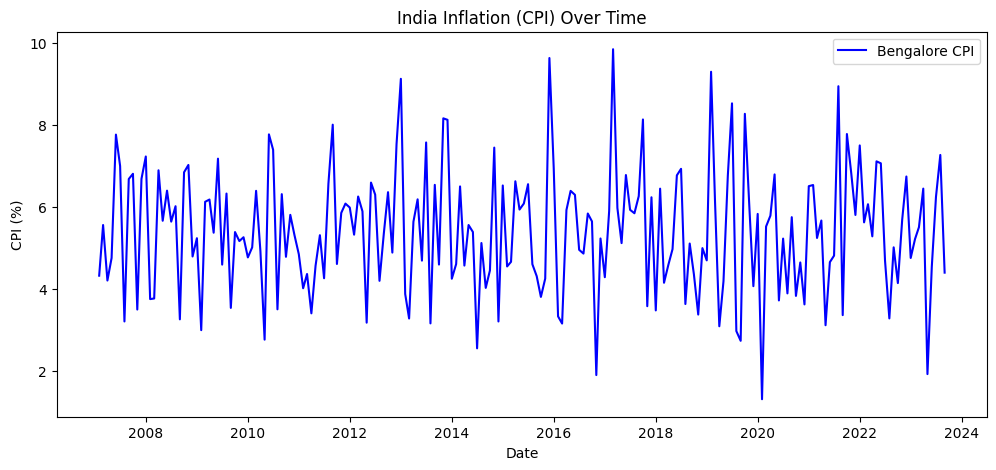

In [12]:
plt.figure(figsize=(12,5))
plt.plot(df["Date"], df["CPI"], label="Bengalore CPI", color="blue")
plt.xlabel("Date")
plt.ylabel("CPI (%)")
plt.title("India Inflation (CPI) Over Time")
plt.legend()
plt.show()


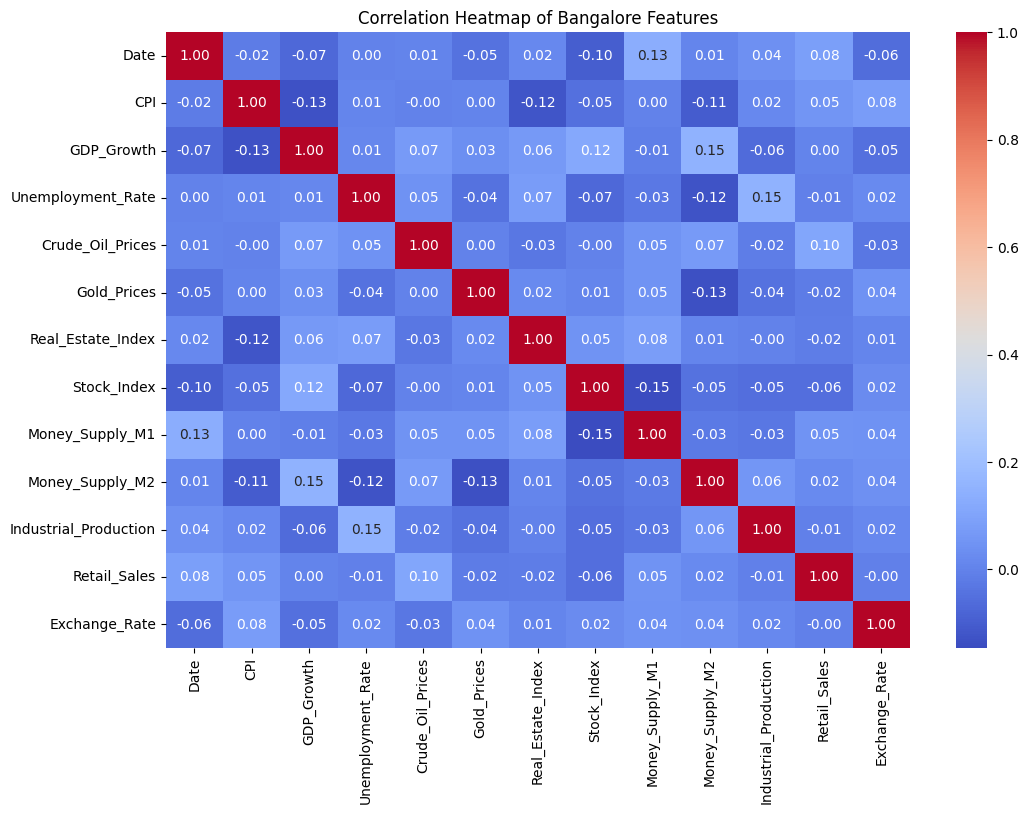

In [13]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Bangalore Features")
plt.show()


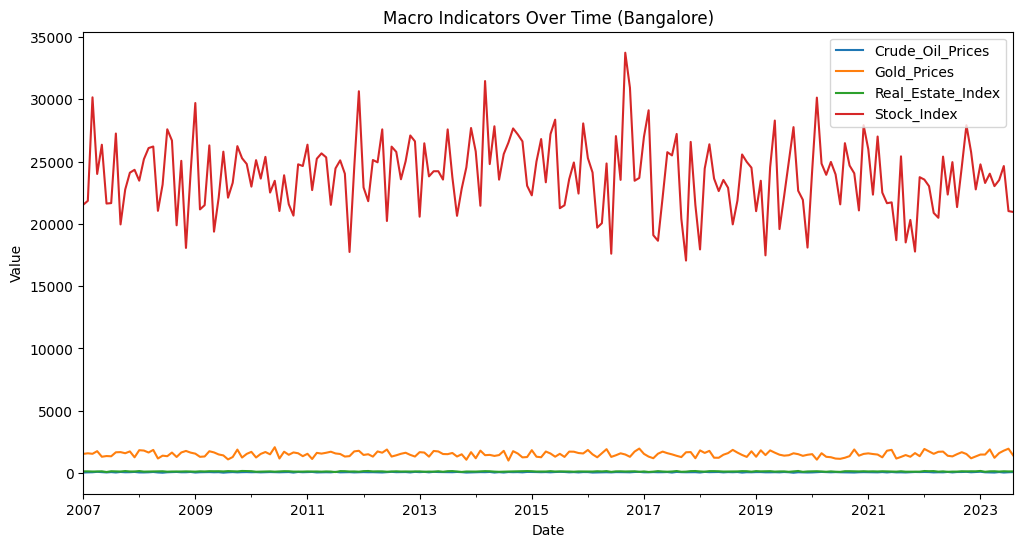

In [15]:
feature_cols = ["Crude_Oil_Prices", "Gold_Prices", "Real_Estate_Index", "Stock_Index"]

df.set_index("Date")[feature_cols].plot(figsize=(12,6))
plt.title("Macro Indicators Over Time (Bangalore)")
plt.ylabel("Value")
plt.show()


In [16]:
df['Gold_diff'] = df['Gold_Prices'].pct_change()
df['RealEstate_diff'] = df['Real_Estate_Index'].pct_change()

In [17]:
df = df.dropna().reset_index(drop=True)

In [18]:
for col in ['Gold_diff', 'RealEstate_diff']:
    for lag in [1, 3, 6, 12]:
        df[f'{col}_lag{lag}'] = df[col].shift(lag)
    # Optional rolling mean/volatility
    df[f'{col}_ma3'] = df[col].rolling(window=3).mean()
    df[f'{col}_vol'] = df[col].rolling(window=3).std()

df = df.dropna().reset_index(drop=True)

In [ ]:
feature_cols = [c for c in df.columns if c not in ['Date']]  # include CPI, Gold_diff, RealEstate_diff + lags
X_scaler = StandardScaler()
features_scaled = X_scaler.fit_transform(df[feature_cols])

# If you want to predict multiple outputs:
y_scaler = StandardScaler()
target_cols = ['Gold_diff', 'RealEstate_diff']
target_scaled = y_scaler.fit_transform(df[target_cols])

SyntaxError: invalid decimal literal (648628381.py, line 1)

In [ ]:
def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):                                           
        Xs.append(X[i:(i+time_steps)])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 12
X_seq, y_seq = create_sequences(features_scaled, target_scaled, TIME_STEPS)

train_size = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

print(f"✅ Train shape: {X_train.shape}, Test shape: {X_test.shape}")

✅ Train shape: (140, 12, 26), Test shape: (35, 12, 26)


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model_gold_real = Sequential([
    GRU(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    GRU(64, activation='tanh'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(2)  # two outputs: Gold_diff, RealEstate_diff
])

model_gold_real.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_gold_real.summary()


c:\Web development\GRU-RNN_InflationModel\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 12, 128)        │        59,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,442 (396.26 KB)

 Trainable params: 101,442 (396.26 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model_gold_real.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 1.0914 - mae: 0.8148 - val_loss: 0.7982 - val_mae: 0.7243
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.9672 - mae: 0.7620 - val_loss: 0.7438 - val_mae: 0.7063
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.9001 - mae: 0.7297 - val_loss: 0.6962 - val_mae: 0.6847
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.8169 - mae: 0.6950 - val_loss: 0.6483 - val_mae: 0.6593
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6908 - mae: 0.6368 - val_loss: 0.5999 - val_mae: 0.6314
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5944 - mae: 0.5997 - val_loss: 0.5756 - val_mae: 0.6260
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5022 - mae: 0.5557 - val_loss: 0.5557 - val_mae: 0.6142
Epoch 8/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.4420 - mae: 0.5231 - val_loss: 0.5743 - val_mae: 0.6183
Epoch 9/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3954 - mae: 

In [24]:
y_pred_scaled = model_gold_real.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_actual = y_scaler.inverse_transform(y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 418ms/step


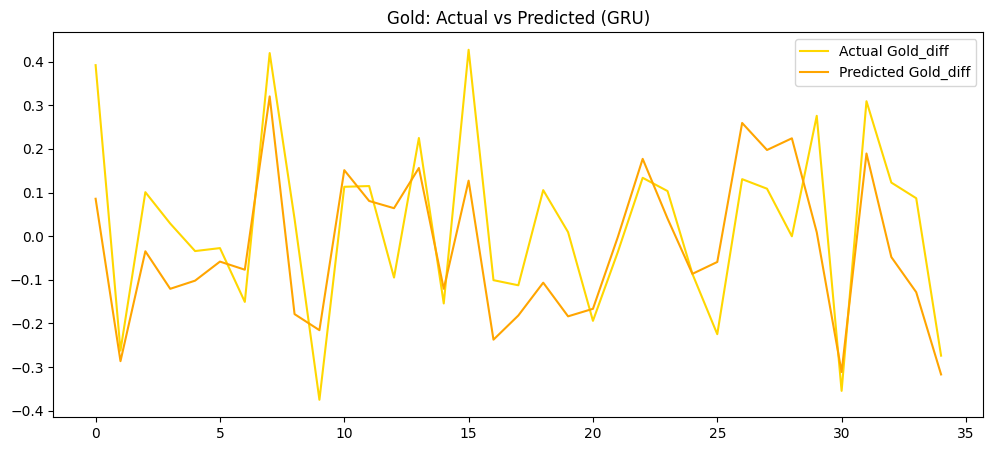

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_actual[:,0], label="Actual Gold_diff", color="gold")
plt.plot(y_pred[:,0], label="Predicted Gold_diff", color="orange")
# plt.plot(y_actual[:,1], label="Actual RealEstate_diff", color="green")
# plt.plot(y_pred[:,1], label="Predicted RealEstate_diff", color="red")
plt.title("Gold: Actual vs Predicted (GRU)")
plt.legend()
plt.show()

In [26]:
model.save("Bengalore_inflation_gru_model_For_Gold_prizes.h5")
print("✅ Model saved as Bengalore_inflation_gru_model_For_Gold_prizes.h5")

✅ Model saved as Bengalore_inflation_gru_model_For_Gold_prizes.h5


In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

for i, col in enumerate(['Gold_diff']):
    actual = y_actual[:, i]
    pred = y_pred[:, i]

    mae = mean_absolute_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    r2 = r2_score(actual, pred)

    # Scaled MAPE relative to typical monthly change
    mean_change = np.mean(np.abs(actual))
    scaled_mape = mae / mean_change * 100

    print(f"\n📌 Target: {col}")
    print(f"MAE: {mae:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Scaled MAPE: {scaled_mape:.2f}%")



📌 Target: Gold_diff
MAE: 0.118417
RMSE: 0.144756
R² Score: 0.4890
Scaled MAPE: 72.33%


In [29]:
# Use percentage change (more variance for the model to learn)
df['RealEstate_diff'] = df['Real_Estate_Index'].pct_change()  # or .diff()
df = df.dropna().reset_index(drop=True)

In [30]:
# Lags
for lag in [1, 3, 6, 12]:
    df[f'RealEstate_diff_lag{lag}'] = df['RealEstate_diff'].shift(lag)

# Rolling mean & volatility
df['RealEstate_ma3'] = df['RealEstate_diff'].rolling(window=3).mean()
df['RealEstate_vol'] = df['RealEstate_diff'].rolling(window=3).std()

df = df.dropna().reset_index(drop=True)

In [31]:
# After feature engineering & creating RealEstate_diff
df = df.dropna().reset_index(drop=True)

# Select features and target
features = df.drop(columns=['Date', 'RealEstate_diff'])  # example
target = df[['RealEstate_diff']]

# Scale
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler()
features_scaled = X_scaler.fit_transform(features)

y_scaler = StandardScaler()
target_scaled = y_scaler.fit_transform(target)

In [32]:
# Only Real Estate differences as target
target_col = 'RealEstate_diff'
y_scaler = StandardScaler()
target_scaled = y_scaler.fit_transform(df[[target_col]])  # NOTE double brackets → 2D

# Sequence preparation
TIME_STEPS = 12
X_seq, y_seq = create_sequences(features_scaled, target_scaled, TIME_STEPS)

# Split train/test
train_size = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

print("✅ X_train:", X_train.shape)
print("✅ y_train:", y_train.shape)

✅ X_train: (129, 12, 27)
✅ y_train: (129, 1)


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model_realestate = Sequential([
    GRU(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    GRU(64, activation='tanh'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)  # single output
])

model_realestate.compile(optimizer='adam', loss='mse', metrics=['mae'])


c:\Web development\GRU-RNN_InflationModel\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [34]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model_realestate.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 1.1241 - mae: 0.7852 - val_loss: 0.7631 - val_mae: 0.7114
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.9661 - mae: 0.7215 - val_loss: 0.7191 - val_mae: 0.7041
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8710 - mae: 0.6993 - val_loss: 0.6909 - val_mae: 0.6991
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.8494 - mae: 0.6905 - val_loss: 0.6713 - val_mae: 0.6789
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7836 - mae: 0.6600 - val_loss: 0.6719 - val_mae: 0.6827
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7051 - mae: 0.6291 - val_loss: 0.6719 - val_mae: 0.6727
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6928 - mae: 0.6270 - val_loss: 0.6443 - val_mae: 0.6598
Epoch 8/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6325 - mae: 0.6010 - val_loss: 0.6298 - val_mae: 0.6578
Epoch 9/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5772 - mae: 

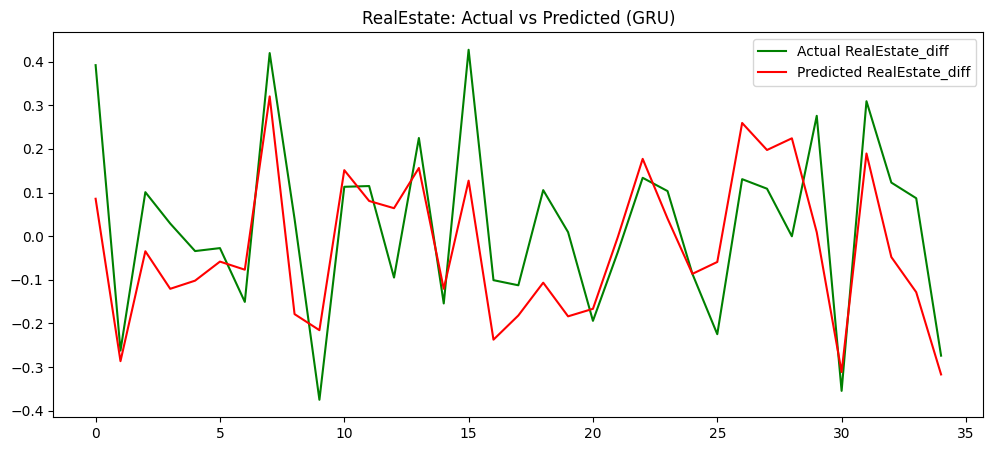

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
# plt.plot(y_actual[:,0], label="Actual Gold_diff", color="gold")
# plt.plot(y_pred[:,0], label="Predicted Gold_diff", color="orange")
plt.plot(y_actual[:,0], label="Actual RealEstate_diff", color="green")
plt.plot(y_pred[:,0], label="Predicted RealEstate_diff", color="red")
plt.title("RealEstate: Actual vs Predicted (GRU)")
plt.legend()
plt.show()

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

for i, col in enumerate(['RealestateDIff']):
    actual = y_actual[:, i]
    pred = y_pred[:, i]

    mae = mean_absolute_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    r2 = r2_score(actual, pred)

    # Scaled MAPE relative to typical monthly change
    mean_change = np.mean(np.abs(actual))
    scaled_mape = mae / mean_change * 100

    print(f"\n📌 Target: {col}")
    print(f"MAE: {mae:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Scaled MAPE: {scaled_mape:.2f}%")



📌 Target: RealestateDIff
MAE: 0.118417
RMSE: 0.144756
R² Score: 0.4890
Scaled MAPE: 72.33%


In [37]:
model.save("Bengalore_inflation_gru_model_For_RealEstate_prizes.h5")
print("✅ Model saved as Bengalore_inflation_gru_model_For_RealEstate_prizes.h5")

✅ Model saved as Bengalore_inflation_gru_model_For_RealEstate_prizes.h5
